In [1]:
# !pip install --upgrade tensorflow scikit-learn numpy
import os
import shutil
import random
import matplotlib.pyplot as plt

In [2]:
DATASET_PATH = '../dataset'
OUTPUT_PATH = 'Dataset_Split'
MAX_SAMPLES = 3000

TRAIN_RATIO = 0.9
VAL_RATIO = 0.0
TEST_RATIO = 0.1

if not (abs(TRAIN_RATIO + VAL_RATIO + TEST_RATIO - 1.0) < 1e-9):
    raise ValueError("Total rasio harus 1.0")

def split_dataset(data_dir, output_dir, train_ratio, val_ratio, test_ratio, max_samples):

    for split in ['train', 'validation', 'test']:
        split_path = os.path.join(output_dir, split)
        if os.path.exists(split_path):
            shutil.rmtree(split_path)
        os.makedirs(split_path, exist_ok=True)

    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

    if not classes:
        print(f"Error: Tidak ditemukan folder kelas di dalam {data_dir}")
        return


    for class_name in classes:
        class_path = os.path.join(data_dir, class_name)
        
        files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        random.shuffle(files)
        
        original_count = len(files)
        
        if original_count > max_samples:
            print(f"Kelas '{class_name}' memiliki {original_count} file. Kurangin menjadi {max_samples}...")
            files = files[:max_samples]
        

        total_files = len(files) 
        
        train_count = int(total_files * train_ratio)
        val_count = int(total_files * val_ratio)
        test_count = total_files - train_count - val_count
        
        if total_files > 0 and train_count == 0:
            print(f"Peringatan: Kelas {class_name} memiliki terlalu sedikit data untuk pembagian yang akurat.")
            
        train_files = files[:train_count]
        val_files = files[train_count : train_count + val_count]
        test_files = files[train_count + val_count :]

        print(f"--- Kelas: {class_name} ---")
        print(f"   Asli: {original_count} -> Dipakai: {total_files}")
        print(f"   Train: {len(train_files)}")
        print(f"   Validation: {len(val_files)}")
        print(f"   Test: {len(test_files)}")


        def copy_files(file_list, split_name):
            destination_dir = os.path.join(output_dir, split_name, class_name)
            os.makedirs(destination_dir, exist_ok=True) 
            
            for f in file_list:
                src_file = os.path.join(class_path, f)
                dst_file = os.path.join(destination_dir, f)
                try:
                    shutil.copy2(src_file, dst_file)
                except Exception as e:
                    print(f"Gagal menyalin {f}: {e}")

        copy_files(train_files, 'train')
        copy_files(val_files, 'validation')
        copy_files(test_files, 'test')
        
    print("\n aman")
    print(f"Dataset yang telah dibagi tersimpan di: {OUTPUT_PATH}")


split_dataset(DATASET_PATH, OUTPUT_PATH, TRAIN_RATIO, VAL_RATIO, TEST_RATIO, MAX_SAMPLES)

Kelas 'cardboard' memiliki 3249 file. Kurangin menjadi 3000...
--- Kelas: cardboard ---
   Asli: 3249 -> Dipakai: 3000
   Train: 2700
   Validation: 0
   Test: 300
--- Kelas: E-waste ---
   Asli: 2918 -> Dipakai: 2918
   Train: 2626
   Validation: 0
   Test: 292
Kelas 'Glass' memiliki 4150 file. Kurangin menjadi 3000...
--- Kelas: Glass ---
   Asli: 4150 -> Dipakai: 3000
   Train: 2700
   Validation: 0
   Test: 300
--- Kelas: metal ---
   Asli: 2808 -> Dipakai: 2808
   Train: 2527
   Validation: 0
   Test: 281
Kelas 'Organic Waste' memiliki 3035 file. Kurangin menjadi 3000...
--- Kelas: Organic Waste ---
   Asli: 3035 -> Dipakai: 3000
   Train: 2700
   Validation: 0
   Test: 300
--- Kelas: paper ---
   Asli: 2730 -> Dipakai: 2730
   Train: 2457
   Validation: 0
   Test: 273
Kelas 'plastic' memiliki 3884 file. Kurangin menjadi 3000...
--- Kelas: plastic ---
   Asli: 3884 -> Dipakai: 3000
   Train: 2700
   Validation: 0
   Test: 300
Kelas 'shoes' memiliki 3954 file. Kurangin menjadi 3000

In [3]:
#Feature extraction
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern, hog
from skimage.color import rgb2hsv
from skimage.segmentation import find_boundaries
from sklearn.decomposition import PCA
import os


def extract_traditional_features(image_path):
    #Load Image
    img = cv2.imread(image_path)
    if img is None:
        return None

    # Resize
    img_resized = cv2.resize(img, (150, 150))
    # img_resized = cv2.resize(img, (64, 64))
    
    #Color Features (HSV Histogram)
    hsv = rgb2hsv(img_resized)
    
    # Normalize + flatten the histograms for each channel
    h_hist = np.histogram(hsv[:, :, 0], bins=16, range=(0, 1))[0]
    s_hist = np.histogram(hsv[:, :, 1], bins=16, range=(0, 1))[0]
    v_hist = np.histogram(hsv[:, :, 2], bins=16, range=(0, 1))[0]

    # FIX: Normalize the histograms by their total sum
    h_hist = h_hist / np.sum(h_hist)
    s_hist = s_hist / np.sum(s_hist)
    v_hist = v_hist / np.sum(v_hist)
    
    color_features = np.concatenate([h_hist, s_hist, v_hist])

    # Texture Features (GLCM)
    gray_img = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    
    # Quantize to reduce the number of gray levels (8 levels)
    bins = np.linspace(0, 256, 9)
    quantized_img = np.digitize(gray_img, bins[:-1]) - 1

    # Calculate GLCM with 4 angles and 2 distances to capture orientation-agnostic texture
    glcm = graycomatrix(
        quantized_img, 
        distances=[3, 5], # Use two different distance scales
        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], # Use 4 directions
        levels=8, 
        symmetric=True, 
        normed=True
    )
    
    # Extract properties, averaging across all 8 distance/angle combinations (2 * 4 = 8)
    # The output shape is (4, 2, 4). We average the 2nd and 3rd axes.
    contrast = graycoprops(glcm, 'contrast').mean()
    energy = graycoprops(glcm, 'energy').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    correlation = graycoprops(glcm, 'correlation').mean()
    
    texture_features = np.array([contrast, energy, homogeneity, correlation])

    # Canny Edge
    # edges = cv2.Canny(gray_img, 100, 200) # Simple Canny edge detection
    # edge_count = np.sum(edges > 0) # Count the number of white pixels (edges)
    # edge_features = np.array([edge_count])

    # Canny Edge (Normalization Applied)
    edges = cv2.Canny(gray_img, 100, 200) # Simple Canny edge detection
    edge_count = np.sum(edges > 0)
    # Calculate Edge Density: (Count of edge pixels) / (Total number of pixels)
    edge_density = edge_count / (gray_img.shape[0] * gray_img.shape[1]) 
    edge_features = np.array([edge_density])

    # HOG Feature
    # hog = cv2.HOGDescriptor()
    # hog_features = hog.compute(img_resized).flatten()

    #use scikit's hog instead of cv2 hog
    hog_features = hog(gray_img,
                   orientations=8,
                   pixels_per_cell=(10, 10),
                   cells_per_block=(2, 2),
                   block_norm='L2-Hys',
                   visualize=False,
                   feature_vector=True)

    # LBP Feature
    radius = 2
    n_points = 8 * radius
    lbp = local_binary_pattern(gray_img, n_points, radius, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    lbp_hist = lbp_hist / np.sum(lbp_hist)


    # Concatenate all features into a single vector
    feature_vector = np.concatenate([
        color_features,
        texture_features,
        edge_features,
        hog_features,
        lbp_hist
    ])

    
    return feature_vector

In [4]:
#dataset splitting
import os
import numpy as np
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight


# Path
base_dir = '../Dataset_Split' 
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


def load_and_extract_features(directory):
    X = []
    y = []
    
    # Identify classes and map them to integers
    class_names = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    class_to_int = {name: i for i, name in enumerate(class_names)}
    
    print(f"Starting feature extraction from: {directory}")
    
    # Loop through classes and files
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        image_files = glob.glob(os.path.join(class_path, '*')) 
        
        print(f"  Processing {class_name} ({len(image_files)} files)...")
        
        for file_path in image_files:
            # Extract feature
            features = extract_traditional_features(file_path)
            
            if features is not None:
                X.append(features)
                y.append(class_to_int[class_name])
                
    return np.array(X), np.array(y), class_names, class_to_int

# Split and extract features
X_train, y_train, labels, class_indices = load_and_extract_features(train_dir)
X_val, y_val, _, _ = load_and_extract_features(val_dir)
X_test, y_test, _, _ = load_and_extract_features(test_dir)
print("Feature vector dimension:", X_train.shape[1])



print("\n--- Feature Matrix Sizes ---")
print(f"Train Features (X_train): {X_train.shape}")
print(f"Validation Features (X_val): {X_val.shape}")
print(f"Test Features (X_test): {X_test.shape}")


# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures have been scaled.")


# Reduce dimensionality
# pca = PCA(n_components=150, random_state=42) # tune if needed

# print("\nApplying PCA dimensionality reduction...")

# X_train_pca = pca.fit_transform(X_train_scaled)
# X_val_pca = pca.transform(X_val_scaled)
# X_test_pca = pca.transform(X_test_scaled)

# cum_var = np.cumsum(pca.explained_variance_ratio_)

# print("PCA Complete!")
# print("Reduced dimensions:", X_train_pca.shape[1])
# print(f"Variance retained by 150 components: {cum_var[149]:.4f}") #TODO: change if PCA is changed

# Reduce dimensionality (variance-based)
pca = PCA(n_components=0.90, random_state=42)

print("\nApplying PCA dimensionality reduction...")

X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("PCA Complete!")
print("Chosen components:", pca.n_components_)
print("Variance retained:", np.sum(pca.explained_variance_ratio_))


# Compute Class Weights
classes = np.unique(y_train)
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
weights = {i: class_weights_array[i] for i in classes} # Convert array to dictionary for model input

print(f"\nJumlah Kelas terdeteksi: {len(labels)}")
print(f"Labels (Class Index): {class_indices}")
print("Class Weights:", weights)

Starting feature extraction from: ../Dataset_Split\train
  Processing E-waste (2334 files)...
  Processing Glass (2400 files)...
  Processing Organic Waste (2400 files)...
  Processing Textiles (2400 files)...
  Processing cardboard (2400 files)...
  Processing metal (2246 files)...
  Processing paper (2184 files)...
  Processing plastic (2400 files)...
  Processing shoes (2400 files)...
  Processing trash (1315 files)...
Starting feature extraction from: ../Dataset_Split\validation
  Processing E-waste (291 files)...
  Processing Glass (300 files)...
  Processing Organic Waste (300 files)...
  Processing Textiles (300 files)...
  Processing cardboard (300 files)...
  Processing metal (280 files)...
  Processing paper (273 files)...
  Processing plastic (300 files)...
  Processing shoes (300 files)...
  Processing trash (164 files)...
Starting feature extraction from: ../Dataset_Split\test
  Processing E-waste (293 files)...
  Processing Glass (300 files)...
  Processing Organic Waste 

In [9]:
import json

with open("labels.json", "w") as f:
    json.dump(labels, f) 

print("labels.json saved successfully")

labels.json saved successfully


In [6]:
# Training

from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Parameter
param_grid = {
    'C': [1, 10, 100], 
    'gamma': ['scale',0.01, 0.001],
    'kernel': ['rbf']
}

# Model
base_svm = SVC(
    kernel='rbf',
    class_weight=weights, 
    random_state=42,
    probability=False
)

# Setup search
grid_search = GridSearchCV(
    estimator=base_svm,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted', #For imbalanced dataset
    verbose=3,
    n_jobs=-1 # Use all available CPU cores
)

print("\nStarting Grid Search Cross-Validation (Hyperparameter Tuning)...")

#Model Training
grid_search.fit(X_train_pca, y_train) 
print("Grid Search Complete!")

# Best model found by the search
svm_model = grid_search.best_estimator_

print("\n--- Best Model Parameters ---")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score ({grid_search.scoring}): {grid_search.best_score_:.4f}")

# Evaluation
y_pred = svm_model.predict(X_test_pca)

print("\n--- Test Set Classification Report (Tuned Model) ---")
print(classification_report(y_test, y_pred, target_names=labels))


Starting Grid Search Cross-Validation (Hyperparameter Tuning)...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Grid Search Complete!

--- Best Model Parameters ---
Best parameters found: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score (f1_weighted): 0.7302

--- Test Set Classification Report (Tuned Model) ---
               precision    recall  f1-score   support

      E-waste       0.79      0.80      0.80       293
        Glass       0.67      0.61      0.64       300
Organic Waste       0.77      0.85      0.81       300
     Textiles       0.81      0.84      0.82       300
    cardboard       0.79      0.81      0.80       300
        metal       0.69      0.67      0.68       282
        paper       0.82      0.86      0.84       273
      plastic       0.70      0.61      0.65       300
        shoes       0.80      0.84      0.82       300
        trash       0.89      0.81      0.85       165

     accuracy                           0

In [10]:
import joblib

#Save Feature Scaler
joblib.dump(scaler, 'scaler.joblib')
print("\nScaler saved as: scaler.joblib")

#Save PCA Transformer
joblib.dump(pca, 'pca_transformer.joblib')
print("PCA Transformer saved as: pca_transformer.joblib")

#Save Trained SVM Model
joblib.dump(svm_model, 'svm_model.joblib')
print("SVM Model saved as: svm_model.joblib")


Scaler saved as: scaler.joblib
PCA Transformer saved as: pca_transformer.joblib
SVM Model saved as: svm_model.joblib



Accuracy: 


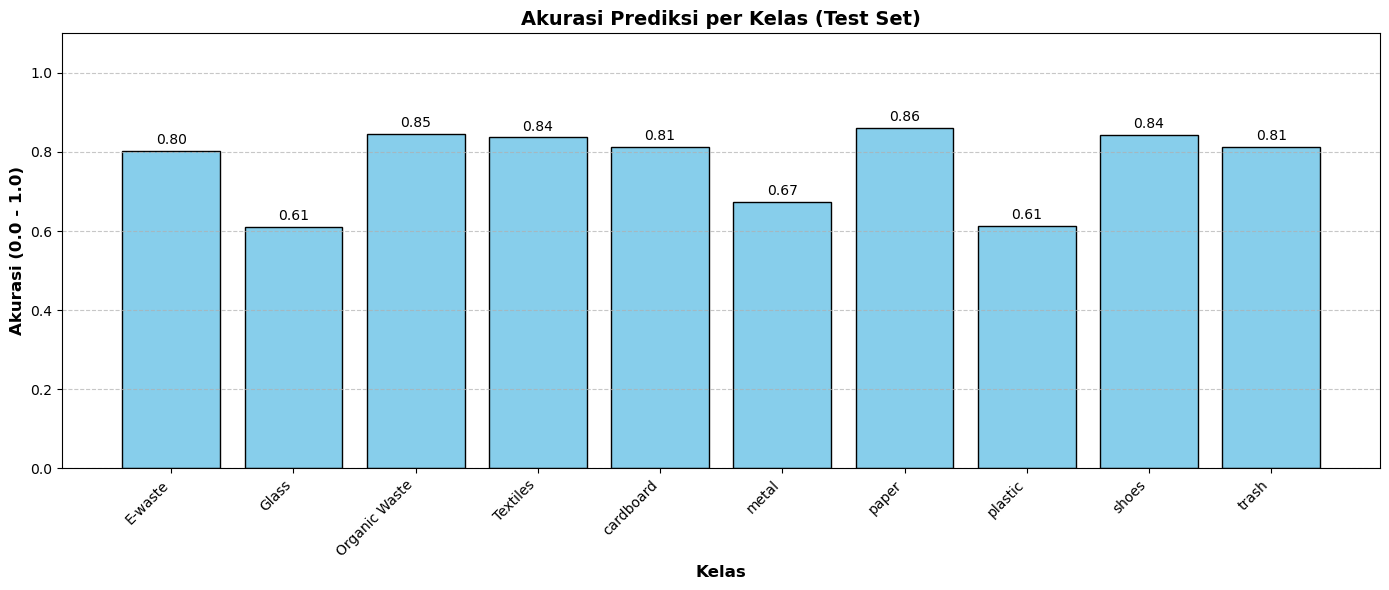


 Evaluasi
               precision    recall  f1-score   support

      E-waste       0.79      0.80      0.80       293
        Glass       0.67      0.61      0.64       300
Organic Waste       0.77      0.85      0.81       300
     Textiles       0.81      0.84      0.82       300
    cardboard       0.79      0.81      0.80       300
        metal       0.69      0.67      0.68       282
        paper       0.82      0.86      0.84       273
      plastic       0.70      0.61      0.65       300
        shoes       0.80      0.84      0.82       300
        trash       0.89      0.81      0.85       165

     accuracy                           0.77      2813
    macro avg       0.77      0.77      0.77      2813
 weighted avg       0.77      0.77      0.77      2813



In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# y_test: Ground truth labels (Test set)
# y_pred: Predictions from svm_model (Test set)
# labels: List of class names 
y_true = y_test        # For consistency with the original code's variable names
class_names = labels   # For consistency with the original code's variable names

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate Accuracy per per class
class_accuracy = cm.diagonal() / cm.sum(axis=1)

print("\nAccuracy: ")
plt.figure(figsize=(14, 6))
bars = plt.bar(class_names, class_accuracy, color='skyblue', edgecolor='black')

plt.xlabel('Kelas', fontsize=12, fontweight='bold')
plt.ylabel('Akurasi (0.0 - 1.0)', fontsize=12, fontweight='bold')
plt.title('Akurasi Prediksi per Kelas (Test Set)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right') 
plt.ylim(0, 1.1) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text labels on top of the bars
for bar, acc in zip(bars, class_accuracy):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01, 
             f'{acc:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\n Evaluasi")
print(classification_report(y_true, y_pred, target_names=class_names))